In [1]:
import os
import re
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
import time
from dypac import Dypac
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

In [2]:
%matplotlib inline

In [20]:
subjects = [100206, 100307, 100408, 100610, 101006, 101309, 101915, 108828,114419,118932,130316,131722]
# 151223 - no LR scan, only RL
#151526,156637,178950,180129,201111 - something wrong with the local files
# Define the path to 4D images
paths = []
for sub in subjects:
    paths.append('/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/{}/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz'.format(sub))
data = paths
data

['/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/100206/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/100307/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/100408/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/100610/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/101006/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/101309/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz',
 '/mnt/c/Users/liz/Desktop/course-materials-20

In [18]:
#from glob import glob
#import os

#wdir = '/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/rfMRI_run2_clean_HCP/'
#data = sorted(glob(os.path.join(wdir,'*.gz')))

In [21]:
len(data)

12

In [5]:
# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

In [22]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 12
finished 2 of 12
finished 3 of 12
finished 4 of 12
finished 5 of 12
finished 6 of 12
finished 7 of 12
finished 8 of 12
finished 9 of 12
finished 10 of 12
finished 11 of 12
finished 12 of 12


In [23]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('MAIN_BASC064_subsamp_features',a = all_features)

In [24]:
feat_file = 'MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

In [25]:
X_features.shape

(12, 2016)

Text(0, 0.5, 'subjects')

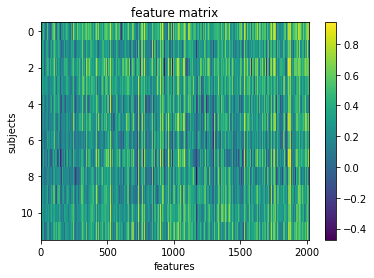

In [26]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

## Get y and assess its distribution

In [27]:
data_path = "/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/HCP_behavioralData.csv"

In [28]:
data = pd.read_csv(data_path).sort_values('Subject')
data.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [29]:
data = data[data['NEO-FFI_Compl'] == True]
neo = ['Subject']
for col in data.columns:
    if (col[0:6] == 'NEOFAC'): neo.append(col)

data_neo = data[neo]
data_neo.describe()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,374908.650542,33.326105,28.202669,34.440367,16.799833,30.643036
std,272805.955931,5.821316,6.276580,5.929432,7.385066,5.965344
min,100004.000000,10.000000,9.000000,11.000000,0.000000,10.000000
25%,154481.500000,30.000000,24.000000,31.000000,12.000000,27.000000
50%,212217.000000,33.000000,28.000000,35.000000,16.000000,31.000000
75%,586161.000000,37.000000,32.000000,38.000000,21.000000,35.000000
max,996782.000000,48.000000,47.000000,48.000000,45.000000,47.000000


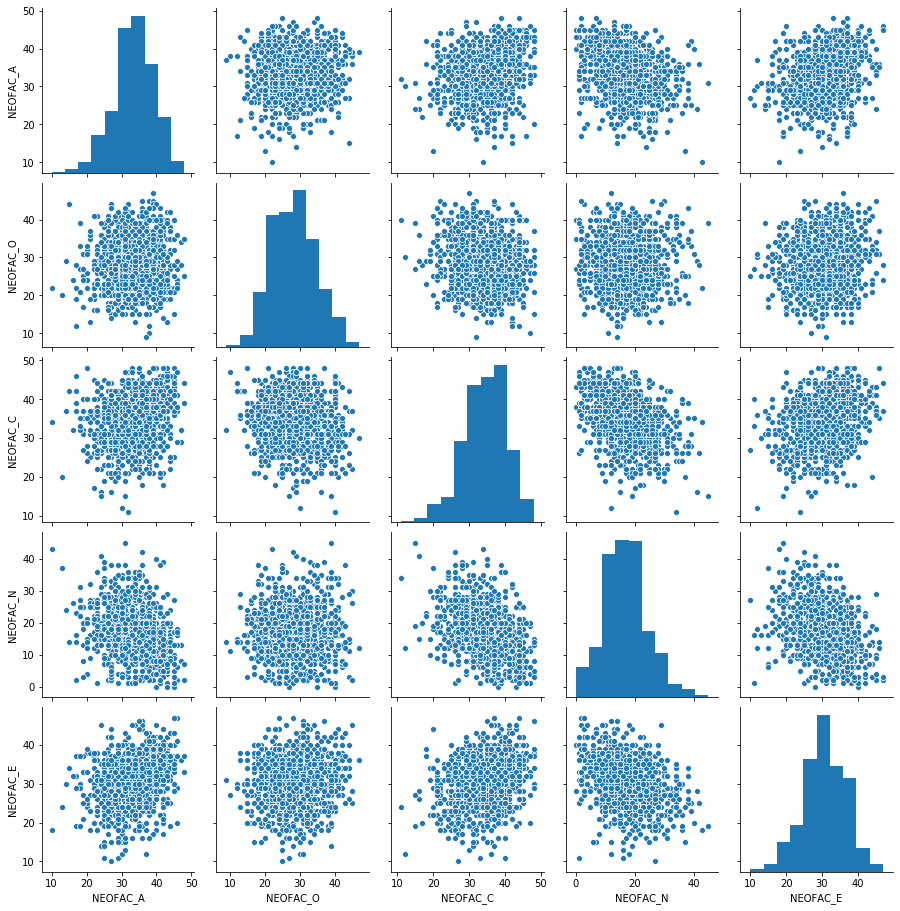

In [14]:
sns.pairplot(data_neo.drop('Subject', axis=1), kind ='scatter')

In [30]:
#filter to subjects I have downloaded 
#180129 highest neuroticism score 43
loc = []
#subjects = [108828,114419,118932,130316,131722,151223,151526,156637,178950,201111,180129]
for sub in subjects:
    loc.append(data_neo.index[data_neo['Subject'] == sub].tolist()[0])

In [31]:
local_data = data_neo.loc[loc].sort_values(by = ['Subject'])
local_data

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
1,100206,29.0,23.0,26.0,21.0,32.0
2,100307,37.0,24.0,35.0,15.0,37.0
3,100408,33.0,29.0,34.0,15.0,33.0
4,100610,31.0,33.0,36.0,7.0,15.0
5,101006,30.0,23.0,39.0,13.0,29.0
8,101309,36.0,22.0,36.0,2.0,26.0
11,101915,35.0,30.0,45.0,8.0,31.0
51,108828,30.0,36.0,30.0,35.0,29.0
78,114419,37.0,32.0,40.0,25.0,37.0
104,118932,33.0,34.0,29.0,25.0,21.0


In [32]:
score_n = local_data['NEOFAC_N']
score_n.value_counts()

25.0    2
15.0    2
39.0    1
28.0    1
35.0    1
8.0     1
2.0     1
13.0    1
7.0     1
21.0    1
Name: NEOFAC_N, dtype: int64

## Trying out support vector regression

In [34]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by neuroticsm score, and also shuffle the data.

X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    score_n, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    #stratify = score_n,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 7 testing: 5


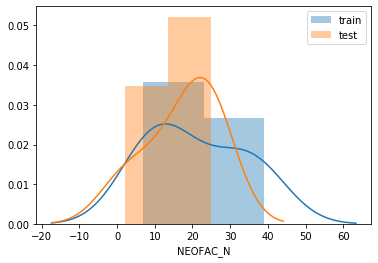

In [35]:
sns.distplot(y_train,label='train')
sns.distplot(y_val,label='test')
plt.legend()

In [40]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear') # define the model

l_svr.fit(X_train, y_train) # fit the model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
# predict the training data based on the model
y_pred = l_svr.predict(X_val) 

# caluclate the model accuracy
acc = l_svr.score(X_val, y_val) 

accuracy (R2) -0.6055984682176343


Text(0.5, 0, 'Predicted Score_N')

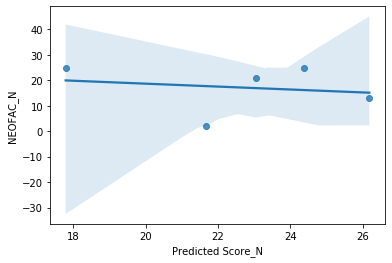

In [43]:
# print results
print('accuracy (R2)', acc)

sns.regplot(y_pred,y_val)
plt.xlabel('Predicted Score_N')